In [1]:
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
import pickle as cp
import tqdm
import matplotlib.pyplot as plt

In [2]:
def log_normal_pdf(param, x):
    return math.log(1 / (math.sqrt(param[1] * 2 * math.pi))) - 1 / 2 * (x - param[0]) * (x - param[0]) / param[1]

class NBC:
    def __init__(self, feature_types, num_classes):
        self.feature_types = feature_types
        self.num_classes = num_classes
        self.theta = []
        self.pi = []
        
    def fit(self, Xtrain, Ytrain):
        self.classes = np.unique(Ytrain)
        T = Ytrain.size
        for i in range(len(self.classes)):
            self.theta.append([])
            X_class_i = Xtrain[Ytrain == self.classes[i]]
            N = X_class_i.size
            means = np.mean(X_class_i, axis=0)
            vars = np.var(X_class_i, axis=0)
            for feature_type, param in zip(self.feature_types, zip(means, vars)):
                if feature_type == "r":
                    mean = param[0]
                    var = param[1] if param[1] > 1e-6 else 1e-6
                    self.theta[i].append((mean, var))
                else:
                    mean = (param[0] * N + 1) / (N + 2)
                    self.theta[i].append(mean)
            self.pi.append(N / T)

    def predict(self, Xtest):
        x_c = []
        for i in range(len(self.classes)):
            x_c.append(np.zeros(Xtest.shape[0]))
            for num in range(len(self.feature_types)):
                if self.feature_types[num] == "r":
                    x_c[i] = x_c[i] + log_normal_pdf(self.theta[i][num], Xtest[..., num])
                else:
                    x_c[i] = x_c[i] + np.log((2 * self.theta[i][num] - 1) * Xtest[..., num] - self.theta[i][num] + 1)
        res = np.empty(shape=(Xtest.shape[0], len(self.classes)))
        for i in range(len(self.classes)):
            res[..., i] = math.log(self.pi[i]) + x_c[i]
        return np.array(self.classes)[np.argmax(res, axis=1)]

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

In [3]:
iris = load_iris()
X_iris, y_iris = iris["data"], iris["target"]
X_vote, y_vote = cp.load(open("voting.pickle", "rb"))

In [4]:
def shuffle(X, y):
    N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    return Xtrain, ytrain, Xtest, ytest

In [5]:
iter = 1000
n = [10 * i for i in range(1, 11)]

100%|██████████| 1000/1000 [02:11<00:00,  7.63it/s]


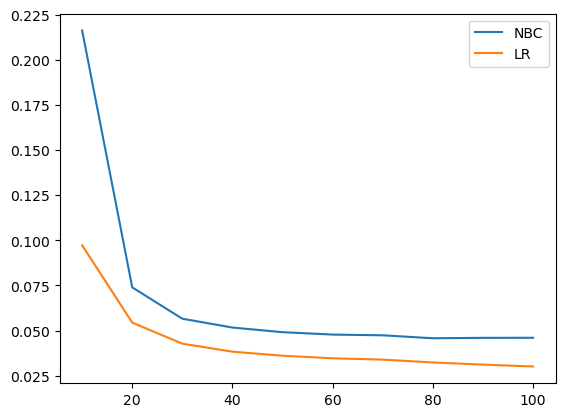

In [6]:
res_nbc = np.zeros((iter, 10))
res_lr = np.zeros((iter, 10))
for i in tqdm.trange(iter):
    Xtrain, ytrain, Xtest, ytest = shuffle(X_iris, y_iris)
    Ntrain = Xtrain.shape[0]
    error_nbc = np.zeros((10,))
    error_lr = np.zeros((10,))
    for j in range(1, 11):
        model = NBC(["r", "r", "r", "r"], 3)
        model.fit(Xtrain[:int(Ntrain * 0.1 * j)], ytrain[:int(Ntrain * 0.1 * j)])
        error_nbc[j - 1] = 1 - model.score(Xtest, ytest)
        model = LogisticRegression(C=5, max_iter=1000)
        model.fit(Xtrain[:int(Ntrain * 0.1 * j)], ytrain[:int(Ntrain * 0.1 * j)])
        error_lr[j - 1] = 1 - model.score(Xtest, ytest)
    res_nbc[i] = error_nbc
    res_lr[i] = error_lr
plt.plot(n, np.mean(res_nbc, axis=0), label="NBC")
plt.plot(n, np.mean(res_lr, axis=0), label="LR")
plt.legend()


100%|██████████| 1000/1000 [00:36<00:00, 27.18it/s]


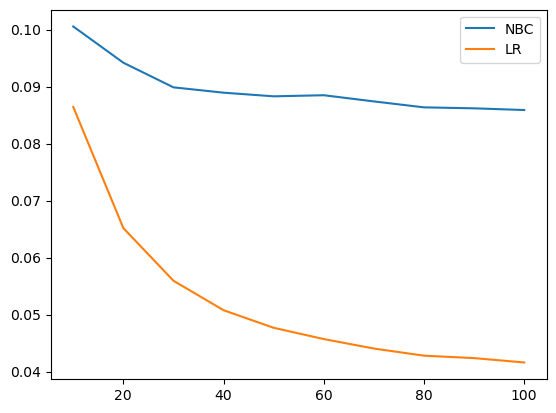

In [7]:
for i in tqdm.trange(iter):
    Xtrain, ytrain, Xtest, ytest = shuffle(X_vote, y_vote)
    Ntrain = Xtrain.shape[0]
    error_nbc = np.zeros((10,))
    error_lr = np.zeros((10,))
    for j in range(1, 11):
        model = NBC(["b" for _ in range(16)], 2)
        model.fit(Xtrain[:int(Ntrain * 0.1 * j)], ytrain[:int(Ntrain * 0.1 * j)])
        error_nbc[j - 1] = 1 - model.score(Xtest, ytest)
        model = LogisticRegression(C=5, max_iter=1000)
        model.fit(Xtrain[:int(Ntrain * 0.1 * j)], ytrain[:int(Ntrain * 0.1 * j)])
        error_lr[j - 1] = 1 - model.score(Xtest, ytest)
    res_nbc[i] = error_nbc
    res_lr[i] = error_lr
plt.plot(n, np.mean(res_nbc, axis=0), label="NBC")
plt.plot(n, np.mean(res_lr, axis=0), label="LR")
plt.legend()